<h1><img align="right" width="350" src="img/ATU-Logo-Full-RGB-Green.jpg"> Project for Programming and Scripting 
</h1>
<p> 
Course: HDip in Computing in Data Analytics <br>
Module: Programming and Scripting <br>
Lecturer: Andrew Beatty
    
Student: Eilis Donohue (G00006088)

A repository for the analysis conducted as part of the Project assessment for  the Programming and Scripting Module of the HDip in Data Analytics beginning January 2023. 

The summary and correlation statistics and plots generated in this notebook are also saved to /summary and /plots, respectively. The analysis is also reproduced in analysis.py.

Software Used: 
 - Python v3.7 and higher
 - Jupyter Notebook 6.4.12   
 </p>

## Table of Contents <a id="toc"></a> 
- [Introduction](#Intro)
- [Python Code for Data Read In](#Data_In)
- [Summary Statistics](#Summary)
- [Correlation Tables](#Correlation)
- [Scatter Plots](#Scatter)
- [Histograms](#Histograms)
- [Rolling Mean Analysis](#Rolling_Mean)
- [Benford's Law / First Digit Law](#Benford)
- [Dataset Comparison - Sources](#Compare)
- [References](#References)

## Introduction <a id="Intro"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>
Fisher's Iris Dataset [1] is a well known dataset dating from the 1930s when analysis of it was published in the Annual Eugenics journal [44] by the academic R.A. Fischer. 

R.A. Fisher was an English polymath who was active in the fields of mathematics, statistics, biology and genetics and made many important contributions to the field of statistical analysis [45]. The iris dataset comprises 50 measurements each of three distinct classes of iris flower found growing in the same meadow. The length and width of the sepal and petal for each flower along with the class or iris type is recorded in the dataset [2]. The flower types are shown in the image below with sepals and petals indicated [36].

Fisher's paper [44] describes a statistical method for determining classification based on measurement data. The original paper described a statistical method of linear discriminant analysis (LDA) [4]. The dataset is still widely referenced today and is used as a training set for discriminant analysis in machine learning applications.

The aim of this analysis is to analyse the dataset using Python, outputting a statistical summary and plots of the data to give insight into the dataset and illustrate trends in the data. The dataset is made available through the UCI archive [46]. 

<figure>
<img src="img/iris-dataset.png"  width="500px">
<figcaption style = 'text-align: center' > Iris types showing sepal and petal taken from [36] </figcaption>
</figure>

## Python Code for Data Read In <a id="Data_In"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

In [91]:
# Importing modules and libraries for the analysis code.
import os
import glob
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
# import datasets from sklearn module to compare the iris data included here with the
# UCI datasets
from sklearn import datasets
# For outputting in the Notebook
from IPython.display import display
from numpy.polynomial import Polynomial as P
# Turn on inline plotting in the notebook [34]
%matplotlib inline
# Setting the filenames for the text file summary output
summary_filename = "data_summary/summary_statistics.txt"
corr_filename = "data_summary/correlation.txt"
plots_folder = "data_plots/"

In [92]:
# ************************ Function definitions ***************************
# Function to calculate the basic statistics of a dataset
def get_summary_stats(data, item=''):
    # Get the basic stats of data with optional argument "item" to differentiate 
    summary_df = pd.DataFrame()
    summary_df['Min (cm)'] = data.min()
    summary_df['Max (cm)'] = data.max()
    summary_df['Mean (cm)'] = data.mean()
    summary_df['Median (cm)'] = data.median()
    summary_df['StDev (cm)'] = data.std()
    summary_df['Variance (cm)'] = data.var() 
    return summary_df

# Function to write a summary of the stats data to a file [5]
def write_to_file(summary_filename, df_data, heading, mode, dec_format="%.2f"):   
    with open (summary_filename, mode) as f:
        # Use to_string for nice formatting for the text file
        df_summary_asstr = df_data.to_string(float_format=dec_format, 
                                                justify='center')
        # write header and data 
        f.write(f'***************** {heading} *****************\n')
        f.write(f'{df_summary_asstr}\n')
        f.write('\n')

# Function to plot Seaborn histograms of each variable 
def plot_histograms(data, var):   
        plt.figure()
        sns.histplot(data, x=var, hue="Class", binwidth=0.2, kde=True)
        plt.savefig(f'{plots_folder}histogram_{var}.png')  

# Run pandas correlation method
def get_corr(data):
    return data.corr()

# Styler for Jupyter notebook table display [12]
def my_styler(df, precision, caption):
    df_styler = df.style.format(precision=precision).set_caption(caption)
    return df_styler

# Styler to highlight values in a table [12]
def styler_highlight_between(df_styler, left, right):
    df_styler = df_styler.highlight_between(color='yellow', axis=0, left=left, right=right, inclusive='both', props=None) 
    return df_styler

# Function which uses numpy to return a linear regression object [19, 20]
def get_linear_fit(numpy_x, numpy_y):
    # return the indexes which have numbers in both x and y (to avoid nans) [30]
    idx = np.isfinite(numpy_x) & np.isfinite(numpy_y)
    # Use the numpy polynomial fit method 
    linear_fit = P.fit(numpy_x[idx], numpy_y[idx], 1)
    return linear_fit

# Function which plots data, calculates the rolling mean, gets a linear fit of rolling mean and the mean of the data
# and plots all of these 
def plot_rollingmean(data, window, iris, var, fig, axis):
    data['Rolling Mean'] = data[var].rolling(window).mean()
    data_np = data.to_numpy()
    # return the linear fit 
    linear_fit = get_linear_fit(data_np[:,0], data_np[:,2])
    # Create a set of x values based on the min and max of the 'x' set 
    x = np.linspace(np.min(data_np[:,0]), np.max(data_np[:,0]))       
    # Calculate fitted y
    y_fitted = linear_fit(x)
    # Convert back to dataframe and put all together
    data = pd.DataFrame(data_np, columns=["Index", var, "Rolling Mean"])
    data['Rolling_linear'] = y_fitted
    data['Mean'] = data[var].mean()
    data = data.drop(columns="Index").copy()
    axis.plot(data[var],'bo', linestyle='')
    axis.plot(data[['Rolling Mean', 'Rolling_linear', 'Mean']])   
    axis.set_ylabel(var +' (cm)')
    axis.set_xlabel('Sample Index')
    return

# Function to create a list of subdirectories [47]
# if subdirectories already exist - all files in them will be deleted.
def make_subdirs(subdir_list):
    # loop over the subdirs to be created
    for subdir in subdir_list:
        # Files deleted in development only
        if subdir in os.listdir():
            #delete_subfolder_files(subdir)
            pass
        else:
            # if not - create it
            os.makedirs(subdir)
    return

# Function to delete files in a subdirectory [7]
# Deleting files function was used in development. Deleting directory not desirable - 
#in case of user already having a subdirectory of same name '''
def delete_subfolder_files(location):
    # delete all files by using wildcard
    location = location + "/*"
    for f in glob.glob(location):
        os.remove(f)
    return

In [93]:
# ***************************** Reading in the data ******************************
# Read in the data from the source file - no header  
data = pd.read_csv('data/iris.data', header=None)
# Make a list of the columns
variables = ["Sepal Length", "Sepal Width", "Petal Length",
             "Petal Width", "Class"]
# List of variables (sepal and petal width and length) without class
variables_wo_class = variables[:-1]
# Assign the header to the data
data.columns = variables
# Output the size of the dataframe and then the first 5 lines to get sense of the data [49]
print(f'Dataframe shape is (rows, columns): {data.shape}\n')
print(f'First 5 lines:\n{data.head(5)}\n')      
# Check for any missing values in the dataframe and sum up on rows and columns [39][40]
print(f'{data.isna().sum().sum()} missing values in dataframe')
# Get the unique classifications 
class_names = data["Class"].unique()

# Create a dataframe without the class column
data_wo_class = data.drop(columns="Class").copy()

Dataframe shape is (rows, columns): (150, 5)

First 5 lines:
   Sepal Length  Sepal Width  Petal Length  Petal Width        Class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

0 missing values in dataframe


In [94]:
# ***************************** Setting up subdirectories ******************************
# Set up the subdirectors for the summary stat files and plots
make_subdirs(['summary', 'plots'])

## Summary Statistics <a id="Summary"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

The summary statistics of the entire dataset and the statistics for each class/iris type separately are given in the tables below. All measurements are in centimetres unless otherwise stated.

From the summary of the whole dataset, the smallest measurement is 0.1 cm (petal width) and the largest measurement is 7.9cm (sepal length). The largest data variance occurs for petal length. Petal length variance is low for the setosa iris but high for the other two species.

In [95]:
# ***************************** Get summary statistics ******************************
# Get the statistics for the whole dataset and write to file
df_summary_all = get_summary_stats(data.drop(columns="Class"))
write_to_file(summary_filename, df_summary_all, "All data", 'wt')
df_styler = my_styler(df_summary_all, 2, "Summary All")
summary_styler_list = [df_styler]
df_corr_all = get_corr(data)
write_to_file(corr_filename, df_corr_all, "All data", 'wt', "%.3f")
df_styler = my_styler(df_corr_all, 2, "Correlation All Data")
df_styler = styler_highlight_between(df_styler, 0.7, 0.99)
df_styler = styler_highlight_between(df_styler, -0.7, -0.99)
# Store in a list to be outputted all together
corr_styler_list = [df_styler]

# Get the statistics for each of the 3 iris types
for item in class_names:
    # Extract the data related to one class of iris
    iris_data = data[data["Class"] == item].copy()
    # Strip the class column before passing to function
    iris_data.drop(columns = "Class", inplace=True) 
    # Get the stats and write to file
    df_summary = get_summary_stats(iris_data)
    df_styler_stats = my_styler(df_summary, 2, item+" Summary Statistics")
    summary_styler_list.append(df_styler_stats)
    write_to_file(summary_filename, df_summary, item, 'at')
    df_corr =  get_corr(iris_data)      
    df_styler = my_styler(df_corr, 2, item + " Correlation")
    df_styler = styler_highlight_between(df_styler, 0.7, 0.99)
    df_styler = styler_highlight_between(df_styler, -0.7, -0.99)
    corr_styler_list.append(df_styler)
    write_to_file(corr_filename, df_corr, item, 'at', "%.2f")  

# Display all the summary stats tables    
for item in summary_styler_list:
    display(item)


,Min (cm),Max (cm),Mean (cm),Median (cm),StDev (cm),Variance (cm)
Sepal Length,4.30,7.90,5.84,5.80,0.83,0.69
Sepal Width,2.00,4.40,3.05,3.00,0.43,0.19
Petal Length,1.00,6.90,3.76,4.35,1.76,3.11
Petal Width,0.10,2.50,1.20,1.30,0.76,0.58


,Min (cm),Max (cm),Mean (cm),Median (cm),StDev (cm),Variance (cm)
Sepal Length,4.30,5.80,5.01,5.00,0.35,0.12
Sepal Width,2.30,4.40,3.42,3.40,0.38,0.15
Petal Length,1.00,1.90,1.46,1.50,0.17,0.03
Petal Width,0.10,0.60,0.24,0.20,0.11,0.01


,Min (cm),Max (cm),Mean (cm),Median (cm),StDev (cm),Variance (cm)
Sepal Length,4.90,7.00,5.94,5.90,0.52,0.27
Sepal Width,2.00,3.40,2.77,2.80,0.31,0.10
Petal Length,3.00,5.10,4.26,4.35,0.47,0.22
Petal Width,1.00,1.80,1.33,1.30,0.20,0.04


,Min (cm),Max (cm),Mean (cm),Median (cm),StDev (cm),Variance (cm)
Sepal Length,4.90,7.90,6.59,6.50,0.64,0.40
Sepal Width,2.20,3.80,2.97,3.00,0.32,0.10
Petal Length,4.50,6.90,5.55,5.55,0.55,0.30
Petal Width,1.40,2.50,2.03,2.00,0.27,0.08


## Correlation Tables <a id="Correlation"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

The correlation tables for the data are shown below (correlation was peformed with Pandas method .corr() [55]). Correlation values higher than 0.75 are highlighted [12]. In the full dataset, high values of correlation are noted for Petal Length/Petal Width, Petal Length/Sepal Length and Petal Width/Sepal Length. 

In [96]:
for item in corr_styler_list:
    display(item)

,Sepal Length,Sepal Width,Petal Length,Petal Width
Sepal Length,1.00,-0.11,0.87,0.82
Sepal Width,-0.11,1.00,-0.42,-0.36
Petal Length,0.87,-0.42,1.00,0.96
Petal Width,0.82,-0.36,0.96,1.00


,Sepal Length,Sepal Width,Petal Length,Petal Width
Sepal Length,1.00,0.75,0.26,0.28
Sepal Width,0.75,1.00,0.18,0.28
Petal Length,0.26,0.18,1.00,0.31
Petal Width,0.28,0.28,0.31,1.00


,Sepal Length,Sepal Width,Petal Length,Petal Width
Sepal Length,1.00,0.53,0.75,0.55
Sepal Width,0.53,1.00,0.56,0.66
Petal Length,0.75,0.56,1.00,0.79
Petal Width,0.55,0.66,0.79,1.00


,Sepal Length,Sepal Width,Petal Length,Petal Width
Sepal Length,1.00,0.46,0.86,0.28
Sepal Width,0.46,1.00,0.40,0.54
Petal Length,0.86,0.40,1.00,0.32
Petal Width,0.28,0.54,0.32,1.00


## Scatter Plots <a id="Scatter"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

The pair plot below shows the scatter plots for all the variables, coloured by iris type. The linear distinctness between iris Setosa and the other iris types is clearly illustrated for all combinations of variables. 

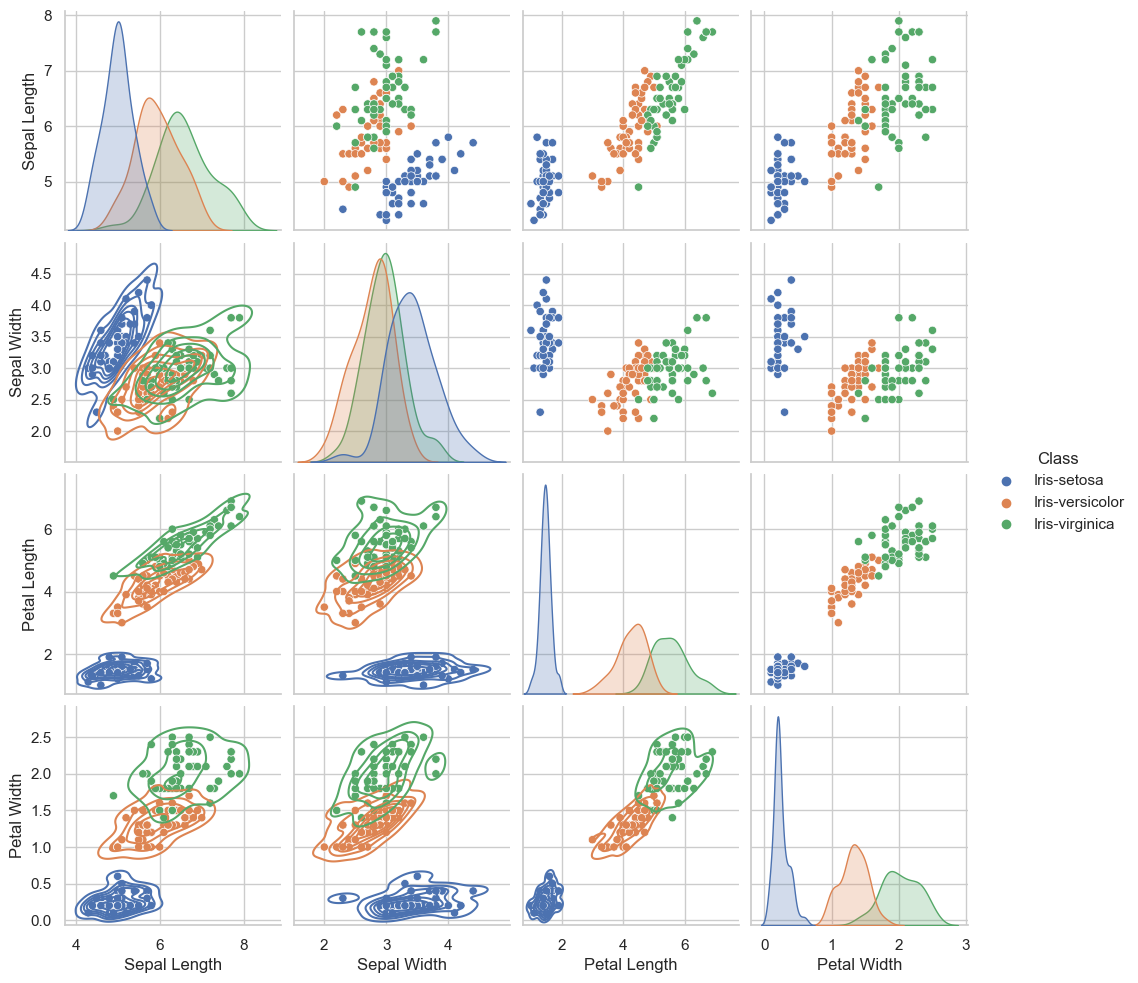

In [97]:
# Plot the pairplot [8] Theme [9]
sns.set_theme(style='whitegrid')
g = sns.pairplot(data, hue="Class", diag_kind="kde")
g.map_lower(sns.kdeplot, levels=7, color=".2")
g.savefig(f"{plots_folder}/scatter_pairplot.png")
plt.show()

<Figure size 640x480 with 0 Axes>

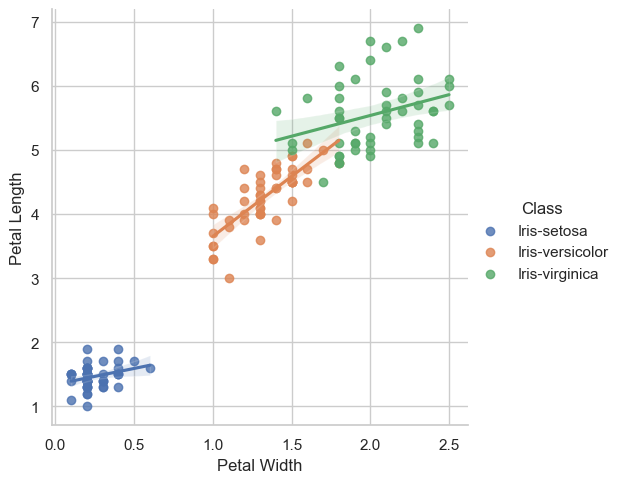

<Figure size 640x480 with 0 Axes>

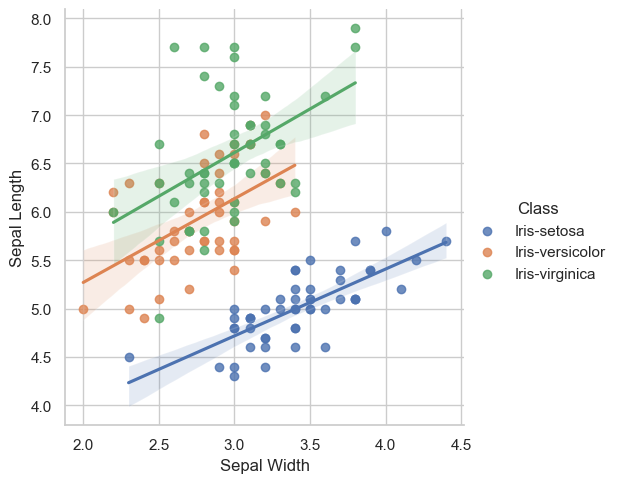

In [98]:
# Plot scatters with linear regression fit [18]
plt.figure()
sns.lmplot(x ='Petal Width', y ='Petal Length', data = data, hue="Class")
plt.savefig(f"{plots_folder}scatter_petal.png")
plt.show()
plt.figure()
sns.lmplot(x ='Sepal Width', y ='Sepal Length', data = data, hue="Class")
plt.savefig(f"{plots_folder}scatter_sepal.png")
plt.show()

## Histograms <a id="Histograms"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>
The histograms below show the distribution of each of the four iris variables.
- Qualitatively, each iris variable separately has approximately a bell-shaped (normal) distribution.
- This distinction between the means of the data or how well spread out the bell curves are is less pronounced for sepal width and length. This clear distinction or in some cases, overlapping of data can also be seen in the scatter plots above. 
- The smaller values of standard distribution for the iris-setosa are illustrated in these plots with all variables apart from Sepal width having smaller deviation relative to the other iris types.

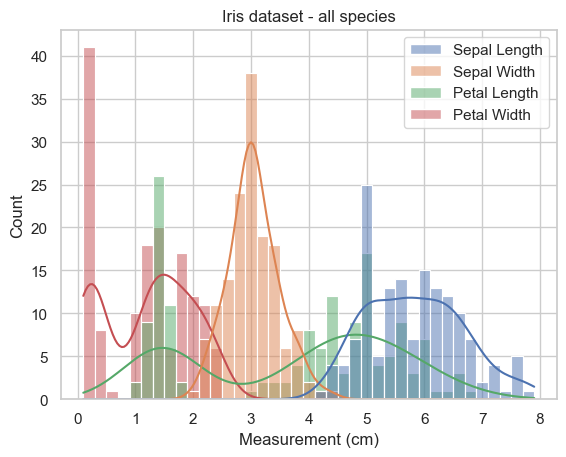

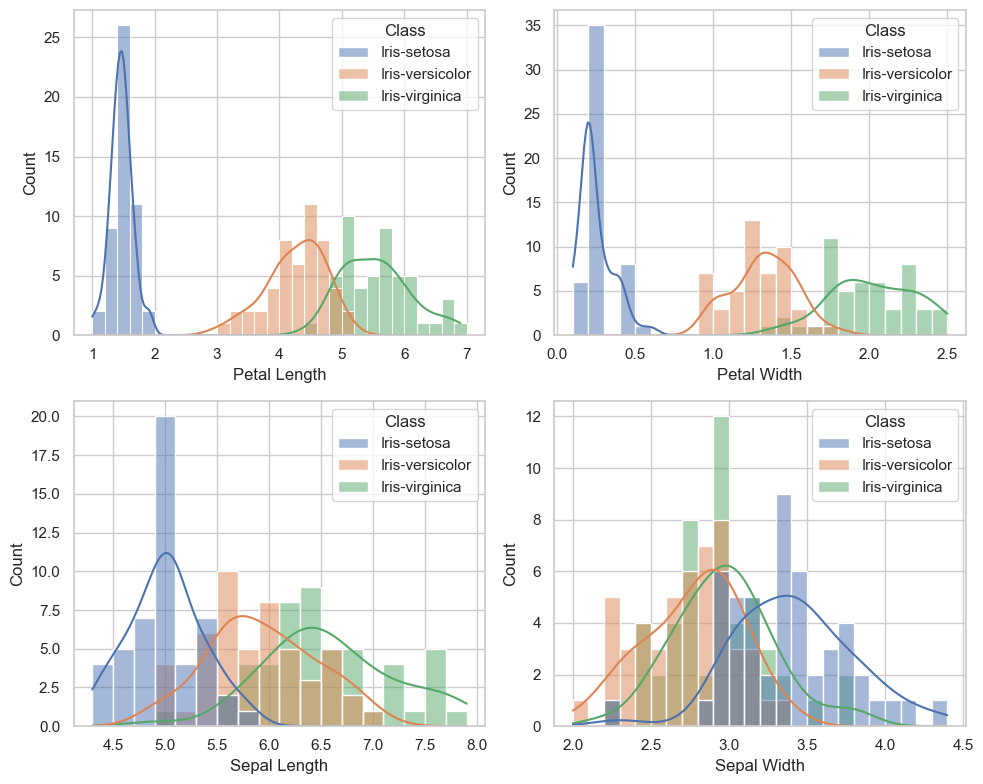

In [99]:
# Plot a histogram of the 4 variables for the entire dataset [48]  
plt.figure()
g = sns.histplot(data_wo_class, binwidth=0.2, kde=True)
g.set(title = "Iris dataset - all species")
g.set_xlabel('Measurement (cm)')
plt.savefig(f'{plots_folder}histogram_all_data.png') 

# Plot the histograms for each variable in the dataset in one figure [15]
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(nrows = 2, ncols =2, figsize=(10,8))
sns.histplot(data, x="Petal Length", hue="Class", binwidth=0.2, kde=True, ax=ax[0,0])
sns.histplot(data, x="Petal Width", hue="Class", binwidth=0.1, kde=True, ax=ax[0,1])
sns.histplot(data, x="Sepal Length", hue="Class", binwidth=0.2, kde=True, ax=ax[1,0])
sns.histplot(data, x="Sepal Width", hue="Class", binwidth=0.1, kde=True, ax=ax[1,1])
fig.tight_layout()
plt.savefig(f"{plots_folder}histogram_4plot.png")
plt.show()

## Rolling Mean Trending <a id="Rolling_Mean"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>
The data is not a timeseries and the measurements or rows in the dataset appear to be randomly ordered within each Iris class. 

Assuming that each row in the dataset is according to the order it was recorded in the field, it may be interesting to note any trends over each iris grouping in the dataset by calculating a rolling mean for the variables in each iris class. 

The measurements are shown as round markers. The rolling mean is also plotted and a linear trend is fitted. The mean of the variable for the given class is also shown in comparison. 

It is noted, though it may not be significant, that there is a decreasing trend for many of the variables with measurements in the first half the dataset having bigger than mean values and those in the second half having smaller values. This may indicate that the recorder (Edgar Anderson) moved from an area tending to have bigger flowers to an area which had smaller flowers. The trend is seen in the 'size' variable also for 2 of the 3 iris types. The size variable is calculated by summing the product of petal width and height and the product of sepal width and height.

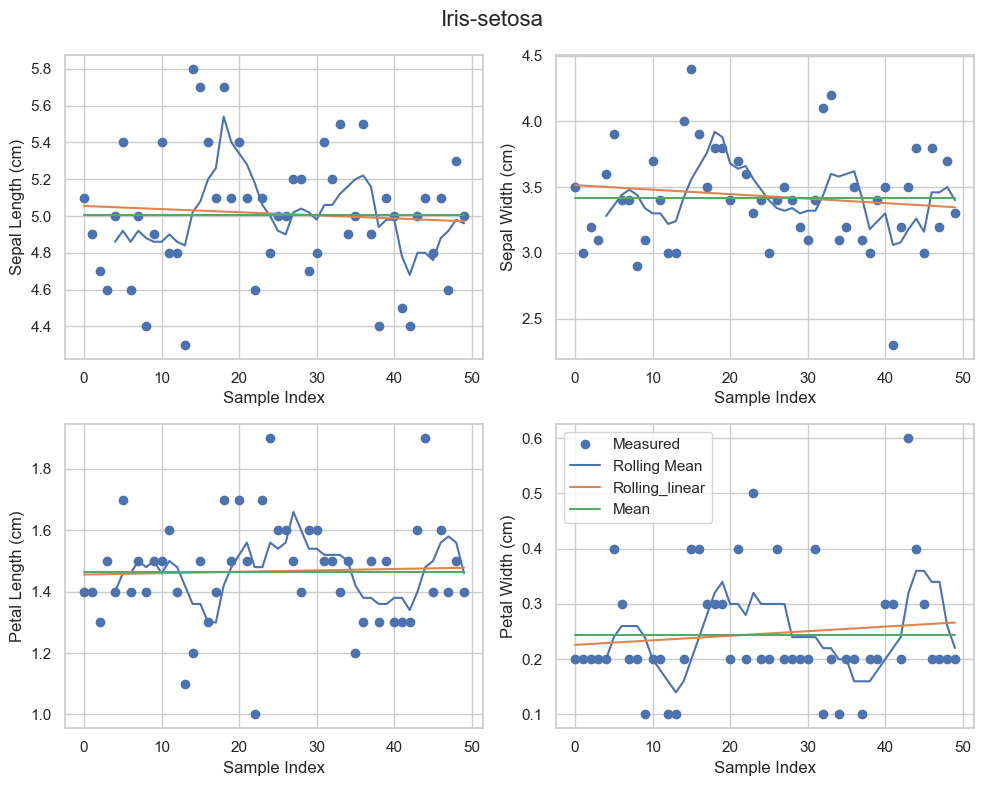

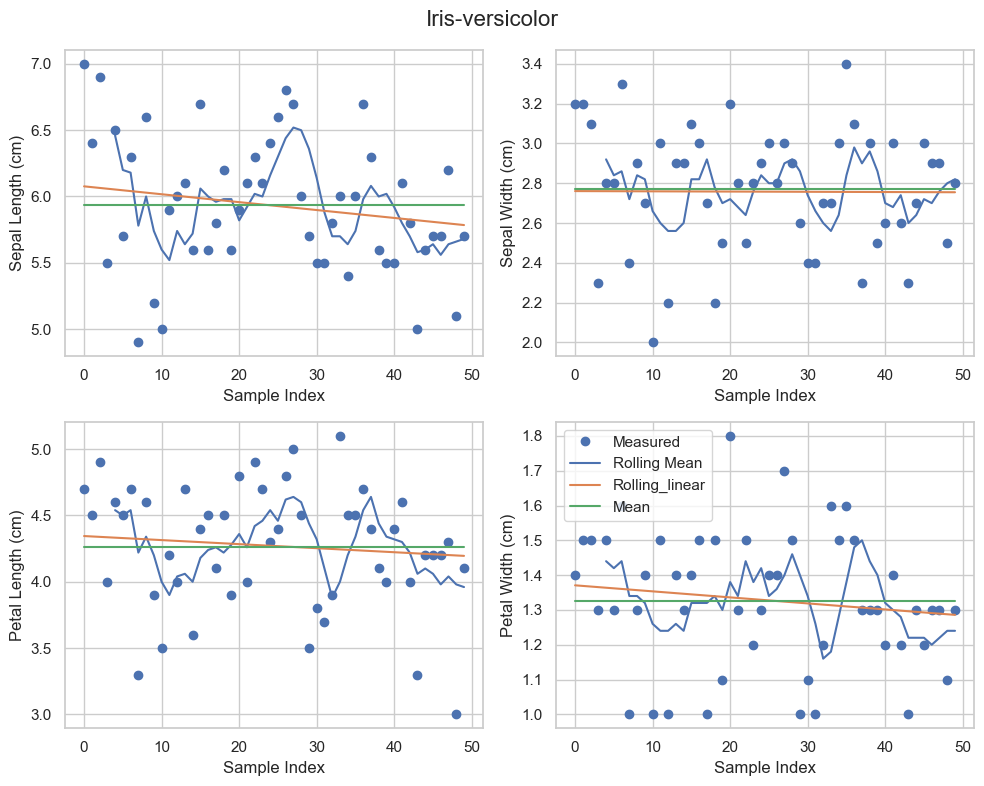

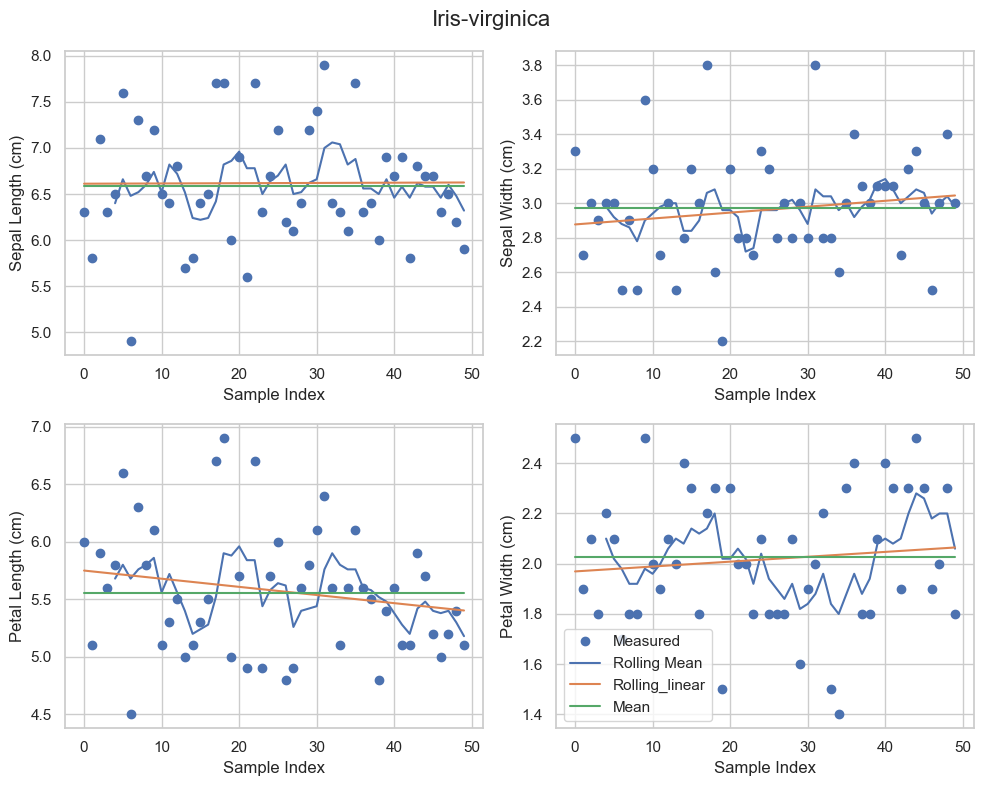

In [100]:
# Loop over the iris types and get the rolling mean plots for each variable [24]
for iris in class_names:
    data_iris = data[data["Class"] == iris].drop(columns = 'Class').copy()
    fig, axs = plt.subplots(2, 2, figsize=(10, 8)) # Figure size set [23]
    # Get a list of axis objects to loop over them [21]
    axis_list = np.array([axs[0,0], axs[0,1], axs[1,0], axs[1,1]]) 
    # loop over the 4 variables using enumerate to get the right axis to plot to [29]
    for count, var in enumerate(variables_wo_class):         
         data_iris_variable = data_iris[var].reset_index() # reset index [31, 32]
         plot_rollingmean(data_iris_variable, 5, iris, var, fig, axis_list[count])
    # Put the title on each figure [28]    
    fig.suptitle(iris, fontsize=16)
    # Make the legend on the last subplot [26]
    axis_list[count].legend(['Measured','Rolling Mean', 'Rolling_linear', 'Mean'])
    # Tight layout [22]
    plt.tight_layout()    
    fig.savefig(f'{plots_folder}line_RollingMean_{iris}.png')    

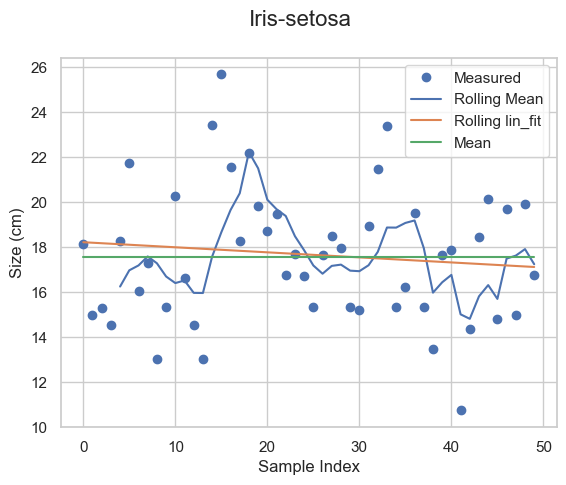

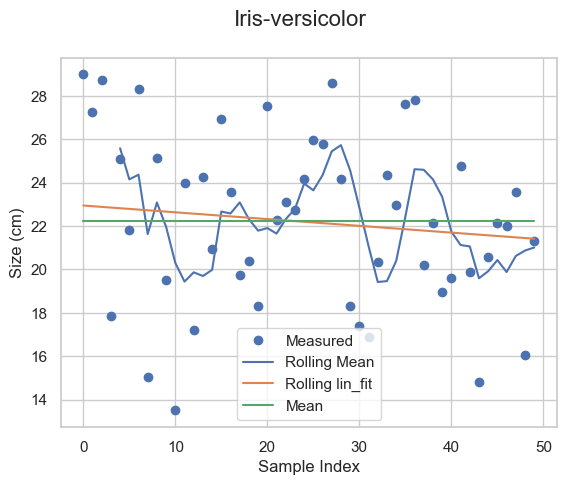

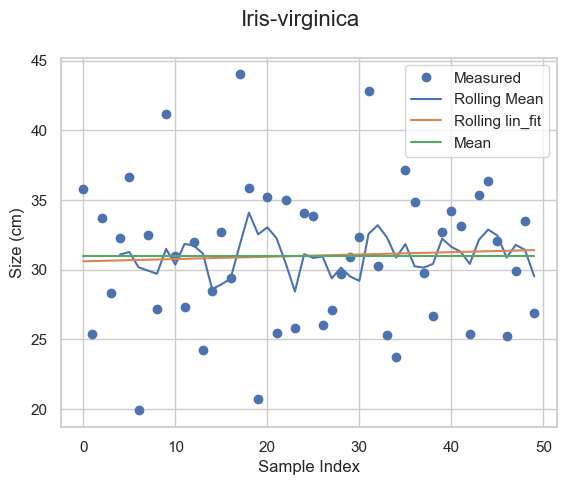

In [101]:
# Creating a new variable called iris_size which is a quantification of the overall size of the flower
# based on following:
iris_size = data['Sepal Width'] * data['Sepal Length'] + \
            data['Petal Width'] * data['Petal Length']     
# Create a new dataframe for this makey-uppy variable            
iris_size = pd.DataFrame(iris_size).copy()
iris_size.columns=['Size']
iris_size['Class'] = data['Class']

# Loop over classes in the size dataframe and create a rolling mean plot for
# each iris as above    
for iris in class_names:
    fig, axs = plt.subplots()   
    data_iris = iris_size[iris_size["Class"] == iris].drop(columns = 'Class').copy()
    data_iris_variable = data_iris.reset_index()
    plot_rollingmean(data_iris_variable, 5, iris, "Size", fig, axs)
    fig.suptitle(iris, fontsize=16)
    axs.legend(['Measured','Rolling Mean', 'Rolling lin_fit', 'Mean'])
    fig.savefig(f'{plots_folder}line_RollingMeanSize_{iris}.png')

## Benford's Law / First Digit Law <a id="Benford"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

Benford's Law or the First Digit Law is an observation that in many real-life datasets, the leading digit is likely to be small [38]. Benford's Law says that in general, the digit '1' appears as the first digit about 30% of the time [38]. Benford's Law tends to be more accurate when values are distributed across multiple orders of magnitude so the law may not be expected to hold for the Iris dataset which, as we can see from the summary above, has values that range from 0.1 to 7.9cm.

The distribution of the first digit of the 600 measurements in the iris dataset is shown below. The digit one appears as first digit 21% of the time in the iris dataset. We know from the summary of the dataset above that the maximum measurement is 7.9cm so there are no measurements with 8 or 9 in the dataset.

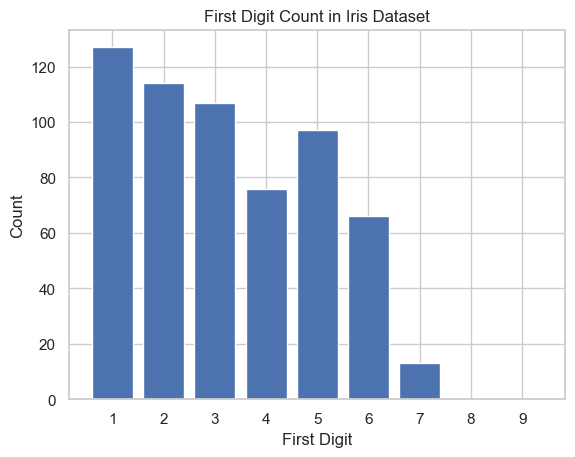

1 appears as the first digit in 21% of the measurements.


In [102]:
# Multiply the whole dataset of measurements by 10 to get millimetres
data_wo_class_mm = data_wo_class * 10
# Convert the dataset to strings [6]
strdata = data_wo_class_mm.astype(str).copy()
# Stack the columns to get one continuous series of values
stacked = strdata.stack().copy()
# Get the first digit of each value [11]
first_digit = stacked.str[0]
# Convert to a list [14][41]
first_digit = first_digit.tolist()

# Define a dictionary keylist and empty dict to store the count of each digit
digit_keylist = ['1','2','3','4','5','6','7','8','9']
digit_count_dict = {}
# Loop over the digits to get store the values in the dictionary
for key in digit_keylist:
    digit_count_dict[key] = first_digit.count(key)   

# Make a barchart of the dictionary values [42]
plt.figure() 
plt.bar(range(len(digit_count_dict)), digit_count_dict.values(), tick_label=
        list(digit_count_dict.keys()))
plt.xlabel('First Digit')
plt.ylabel('Count')
plt.title('First Digit Count in Iris Dataset')
plt.savefig(f'{plots_folder}barplot_BenfordsLaw.png')
plt.show()
        
# Get the number of times 1 is the first digit as percentage of total [43]
digit1_percent = digit_count_dict['1'] / len(first_digit) * 100
print(f'1 appears as the first digit in {digit1_percent:.0f}% of the measurements.')

## Dataset Comparison - Sources <a id="Compare"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>
While the dataset analysed in this project comes from the UCI website, there is another dataset included in the folder called "bezdekIris.data". When the two datasets are compared, it can be seen that there are some discrepancies between the two datasets. Indeed, the UCI website notes the discrepancies [46]. The iris dataset dates back to the 1930s and it seems that there are a number of versions of the dataset (with small differences) referenced in many papers. This is discussed in [51]. The following analysis shows the differences in some of the datasets with "basecase" referring to the UCI dataset that was used in this project analysis. The version which is included in the sklearn library is also checked for accurary.

Firstly, the two UCI datasets are compared (basecase and bezdekIris). 


In [103]:
# Read in BezdekIris (this is the 2nd dataset included in the UCI repository)
bezdek_iris = pd.read_csv('data/bezdekIris.data', header=None)
bezdek_iris.columns = variables
# Do a comparison between the basecase data and the Bezdek Iris data [53]
print("Comparison between the basecase UCI data and the UCI Bezdek data:")
data.compare(bezdek_iris)

Comparison between the basecase UCI data and the UCI Bezdek data:


Sepal Width       Petal Length       Petal Width      
          self other         self other        self other
34         NaN   NaN          NaN   NaN         0.1   0.2
37         3.1   3.6          1.5   1.4         NaN   NaN

Next a comparison is made between the basecase and the sklearn included iris data. From the comparison below, it seems that the basecase dataset differs from the sklearn dataset, with the same measurements showing the same discrepancies. From this, it can be concluded that the Bezdek iris dataset is the same as the sklearn iris dataset and is also the same as the iris dataset included in the seaborn plotting module. Therefore, it can probably be concluded that the UCI iris dataset has been superseded in light of the discrepancies noted by Bezdek et al.

In [104]:
# Load the sklearn iris dataset - bunch object with different types
sklearn_iris_bunch = datasets.load_iris()
# Get the data 
sklearn_iris = pd.DataFrame(sklearn_iris_bunch.data)
# Data preview - 
#print(sklearn_iris)
#print(sklearn_iris_bunch)
# check if data layout is the same as the UCI datasets - it is
# so can assign the same columns index
print(sklearn_iris_bunch.feature_names) 
print(variables_wo_class)
# Put the dataframe together using the same columns headers to aid comparison
sklearn_iris.columns = variables_wo_class
# Add the class column (which is .target)
sklearn_iris['Class'] = sklearn_iris_bunch.target
# Class is a digit with the reference in .target_names
print(sklearn_iris.head(5))
print(sklearn_iris_bunch.target_names)
# Set up a reference dictionary to replace Class data with the iris name
ref_dict = {}
for i, row in enumerate(sklearn_iris_bunch.target_names.tolist()):
    ref_dict[i] = "Iris-" + row
# Replace the class data with the dictionary as a reference [52]    
sklearn_iris['Class']  = sklearn_iris['Class'].replace(ref_dict)
# Compare the sklearn dataset with the basecase
print("Comparison between the basecase UCI data and sklearn dataset:")
print(data.compare(sklearn_iris))
print("Comparison between the Bezdek Iris dataset and sklearn dataset:")
print(bezdek_iris.compare(sklearn_iris))
# Finally check the seaborn iris dataset
seaborn_iris = sns.load_dataset('iris')
print(seaborn_iris.head(5))
# Format to make the headers and class the same
seaborn_iris.columns = data.columns
seaborn_iris['Class'] = "Iris-" + seaborn_iris['Class']
print("Finally check the Seaborn dataset against the Bezdek iris dataset")
print(seaborn_iris.compare(bezdek_iris))

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
   Sepal Length  Sepal Width  Petal Length  Petal Width  Class
0           5.1          3.5           1.4          0.2      0
1           4.9          3.0           1.4          0.2      0
2           4.7          3.2           1.3          0.2      0
3           4.6          3.1           1.5          0.2      0
4           5.0          3.6           1.4          0.2      0
['setosa' 'versicolor' 'virginica']
Comparison between the basecase UCI data and sklearn dataset:
   Sepal Width       Petal Length       Petal Width      
          self other         self other        self other
34         NaN   NaN          NaN   NaN         0.1   0.2
37         3.1   3.6          1.5   1.4         NaN   NaN
Comparison between the Bezdek Iris dataset and sklearn dataset:
Empty DataFrame
Columns: []
Index: []
   sepal_length  sepal_width  petal_length  

From looking at the 35th and 38th entry for Iris-setosa on the data table in Fisher's original paper, it seems that the UCI dataset or basecase data is not completely accurate. The values which were flagged in the comparisons above, correspond with those values in the Bezdek, Sklearn and seaborn versions. This is noted in the correspondence in the IEEE journal [51]. The small differences do not affect any analysis carried out above but it does highlight the issue of data corruption which can happen.

<figure>
<img src="img/fisher_table.png"  width="500px">
<figcaption style = 'text-align: center' > The dataset from Fisher's article [44] </figcaption>
</figure>

## References <a id="References"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

1. Fisher's Iris Dataset: https://archive.ics.uci.edu/ml/datasets/iris 
2. Iris data set wiki page: https://en.wikipedia.org/wiki/Iris_flower_data_set
3. Seaborn histograms: https://seaborn.pydata.org/generated/seaborn.histplot.html?highlight=histplot#seaborn.histplot
4. Linear Discriminant Analysis: https://en.wikipedia.org/wiki/Linear_discriminant_analysis
5. Write a dataframe to a text file: https://stackoverflow.com/questions/31247198/python-pandas-write-content-of-dataframe-into-text-file 
6. Pandas documentation, https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_string.html 
7. Stack Overflow "How to delete the contents of a folder", https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder 
8. Seaborn Documentation, Pairplots https://seaborn.pydata.org/generated/seaborn.pairplot.html
9. Seaborn set theme: https://seaborn.pydata.org/generated/seaborn.set_theme.html
10. Remove seaborn legend title: https://stackoverflow.com/questions/51579215/remove-seaborn-lineplot-legend-title 
11. Get a string character: https://stackoverflow.com/questions/40950310/strip-trim-all-strings-of-a-dataframe
12. Stylers for pandas: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
13. General Plotting: https://jovian.com/suresh-kumar-m/python-matplotlib-data-visualization
14. Pandas to list: https://www.geeksforgeeks.org/python-pandas-series-tolist/
15. Plotting multiple histograms in a grid: https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
16. Box plots and legends: https://stackoverflow.com/questions/62252493/create-a-single-legend-for-multiple-plot-in-matplotlib-seaborn
17. Subplots https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
18. Regression plots in seaborn https://datavizpyr.com/add-regression-line-per-group-with-seaborn-in-python/#:~:text=We%20will%20start%20with%20two%20ways%20in%20Seaborn,adding%20regression%20line%20per%20group%20can%20be%20meaningful.
19. Polynomial fit: https://stackoverflow.com/questions/67728068/get-the-coefficients-of-a-polynomial-with-numpy
20. Numpy polynomial: https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html#numpy.polynomial.polynomial.Polynomial.fit
21. Looping over axis list https://stackoverflow.com/questions/20288842/matplotlib-iterate-subplot-axis-array-through-single-list (accessed Apr 29 2023)
22. Tight layout on subplots: https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html 
23. Figure size: https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots 
24. Plotting on specific axis: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html 
25. Extracting first digits from string in pandas series: https://stackoverflow.com/questions/51607400/how-to-extract-first-8-characters-from-a-string-in-pandas 
26. Pyplot legend https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
27. Pyplot.plot() fomrmatting https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
28. Pyplot subplots https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/figure_title.html
29. Python enumerate https://realpython.com/python-enumerate/
30. Index numpy for regression with nans: https://stackoverflow.com/questions/28647172/numpy-polyfit-doesnt-handle-nan-values
31. Pandas reset index: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
32. Pandas index to column https://stackoverflow.com/questions/20461165/how-to-convert-index-of-a-pandas-dataframe-into-a-column
33. Pyplot.scatter() https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
34. Plotting inline in Jupyter notebook: https://data36.com/linear-regression-in-python-numpy-polyfit/
35. Jupyter notebook and scrollable frames: https://stackoverflow.com/questions/69353832/why-does-jupyter-sometimes-put-plots-in-scrollable-frames#:~:text=The%20reason%20it's%20so%20is,is%20more%20of%20a%20feature.
36. Iris image: https://machinelearninghd.com/iris-dataset-uci-machine-learning-repository-project/
37. Text align in figure caption: https://stackoverflow.com/questions/19138758/how-to-align-caption-underneath-image 
38. Benfords Law: https://en.wikipedia.org/wiki/Benford%27s_law 
39. Pandas isna: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html 
40. Count isna in a dataframe: https://sparkbyexamples.com/pandas/count-nan-values-in-pandas/#:~:text=If%20we%20want%20to%20count,values%20in%20the%20entire%20DataFrame. 
41. Pandas dataframe to list: https://pandas.pydata.org/docs/reference/api/pandas.Series.tolist.html 
42. Plot a dictionary as a barchart: https://www.tutorialspoint.com/plot-a-bar-using-matplotlib-using-a-dictionary 
43. Format a float in an f string: https://zetcode.com/python/fstring/ 
44. Annals of Eugenics - September 1936 - The Use of Multiple Measurements in Taxonomic Problems
45. Ronald Fisher: https://en.wikipedia.org/wiki/Ronald_Fisher
46. UCI Archive - Fisher's Iris dataset: https://archive.ics.uci.edu/ml/datasets/Iris/
47. Make a directory: https://www.geeksforgeeks.org/create-a-directory-in-python/
48. Set axis label on seaborn histogram: https://www.delftstack.com/howto/seaborn/set-axis-labels-seaborn-python/
49. Pandas shape and head: https://pandas.pydata.org/docs/reference/frame.html
50. Sklearn iris dataset: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
51. Bezdek correspondence: IEEE Transactions on Fuzzy Systems, VOL. 7, NO. 3, JUNE 1999 "Will the real Iris Data Please Stand Up?"
52. Pandas replace: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
53. Pandas compare: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.compare.html
54. Load seaborn iris dataset: https://seaborn.pydata.org/generated/seaborn.load_dataset.html
55. Pandas correlation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html